# Clone du projet "Layerwise Relevance Propagation pour l'analyse d'image"
### Nouvelles données utilisées : Mnist dataset
### Réalisé par : Moqim Ghizlan et Thibaut JUILLARD


Ce notebook implémente un modèle de réseau de neurones convolutif (CNN) sur le dataset MNIST, suivi de trois variantes de la méthode LRP pour interpréter les décisions du modèle :
- LRP standard
- LRP-ε (epsilon rule)
- LRP-αβ (alpha-beta rule)

## Installation des bibliothèques nécessaires

---




In [ ]:
!pip install torch torchvision matplotlib numpy

## Importation des bibliothèques

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


## Transformation des images en tenseurs et normalisation

In [ ]:
# Transformation des images : conversion en tenseurs et normalisation des pixels entre -1 et 1
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertit les images en tenseurs PyTorch
    transforms.Normalize((0.5,), (0.5,))  # Normalise les pixels pour centrer la distribution autour de 0
])


## Chargement des datasets MNIST (train et test)

In [ ]:
# Chargement du dataset MNIST pour l'entraînement et le test
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)  # Données d'entraînement
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)  # Données de test

# Préparation des DataLoaders pour le traitement par lots
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)  # Mélange les données à chaque époque
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)   # Ne mélange pas les données de test


# Définition du Modèle CNN

In [ ]:
class CNN(nn.Module):
    """Réseau de Neurones Convolutif (CNN) pour la classification MNIST."""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)   # Première couche convolutionnelle
        self.relu = nn.ReLU()                                               # Fonction d'activation ReLU
        self.pool = nn.MaxPool2d(2, 2)                                      # Couche de pooling pour réduire la dimensionnalité
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Deuxième couche convolutionnelle
        self.fc1 = nn.Linear(64 * 7 * 7, 128)                               # Première couche entièrement connectée
        self.fc2 = nn.Linear(128, 10)                                       # Couche de sortie pour la classification des 10 chiffres (0 à 9)

    def forward(self, x):
        x = self.relu(self.conv1(x))  # Application de la première convolution suivie de ReLU
        x = self.pool(x)              # Réduction de la taille avec le max pooling
        x = self.relu(self.conv2(x))  # Deuxième convolution suivie de ReLU
        x = self.pool(x)              # Réduction de la taille avec le max pooling
        x = x.view(-1, 64 * 7 * 7)    # Aplatissement des données pour la couche entièrement connectée
        x = self.relu(self.fc1(x))    # Activation ReLU après la première couche fully connected
        x = self.fc2(x)               # Couche de sortie sans activation (softmax sera appliqué plus tard si nécessaire)
        return x


## Initialisation du modèle

In [ ]:
model = CNN()

## Définition de la fonction de perte et de l'optimiseur

In [ ]:
criterion = nn.CrossEntropyLoss()  # Fonction de perte pour les tâches de classification multi-classes
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimiseur Adam pour la mise à jour des poids du modèle


# Entraînement du Modèle

In [ ]:
num_epochs = 5  # Nombre d'époques d'entraînement

for epoch in range(num_epochs):
    running_loss = 0.0  # Accumulateur de la perte pour chaque époque

    for images, labels in train_loader:
        optimizer.zero_grad()  # Réinitialisation des gradients à zéro
        outputs = model(images)  # Prédiction du modèle sur les images d'entrée
        loss = criterion(outputs, labels)  # Calcul de la perte entre les prédictions et les étiquettes réelles
        loss.backward()  # Propagation du gradient en arrière
        optimizer.step()  # Mise à jour des poids du modèle
        running_loss += loss.item()  # Accumulation de la perte

    # Affichage de la perte moyenne pour l'époque en cours
    print(f"Époque {epoch+1}/{num_epochs}, Perte : {running_loss/len(train_loader):.4f}")


Époque 1/5, Perte : 0.1498
Époque 2/5, Perte : 0.0461
Époque 3/5, Perte : 0.0296
Époque 4/5, Perte : 0.0235
Époque 5/5, Perte : 0.0179


# Implémentation des Méthodes LRP

## 1. LRP Standard

La formule de propagation de la relevance avec la méthode **LRP standard** est définie comme suit :

$$
R_i = \sum_j \frac{z_{ij}}{\sum_i z_{ij}} R_j
$$

Où :  
- \$( z_{ij} = x_i \cdot w_{ij} \)$ représente la contribution de l'activation de l'entrée \$( x_i \$) pondérée par le poids \$( w_{ij} \$) de la connexion entre les neurones des couches \$( i \$) et \$( j \$).  
- \$( R_j \$) est la relevance attribuée au neurone \$( j \$) de la couche suivante.  
- Le terme \$( \sum_i z_{ij} \$) assure la normalisation de la distribution des relevances, garantissant ainsi la conservation des scores lors de la rétropropagation.

Cette règle simple répartit la relevance en fonction des contributions proportionnelles des neurones d'entrée.


In [ ]:
def lrp(model, image, label):
    """
    Implémentation de la méthode LRP standard pour expliquer les décisions du modèle.

    Args:
        model (nn.Module): Le modèle CNN entraîné.
        image (torch.Tensor): L'image d'entrée à interpréter.
        label (int): L'étiquette réelle de l'image.

    Returns:
        relevance_map (numpy.ndarray): Carte de relevance indiquant l'importance des pixels.
        pred_label (int): Étiquette prédite par le modèle.
    """
    model.eval()  # Passage en mode évaluation
    image.requires_grad = True  # Autorise la propagation du gradient à travers l'image

    output = model(image)  # Prédiction du modèle
    pred_label = output.argmax().item()  # Étiquette prédite par le modèle

    relevance = output[0, pred_label]  # Sélection de la sortie correspondant à l'étiquette prédite
    relevance.backward()  # Propagation en arrière pour obtenir les gradients

    relevance_map = image.grad.squeeze().detach().numpy()  # Extraction de la carte de relevance
    return relevance_map, pred_label


## 2. LRP-ε (Epsilon Rule)

La règle **LRP-ε** modifie la formule de propagation de la relevance en ajoutant un petit terme **ε (epsilon)** au dénominateur pour éviter des résultats instables :  

$$
R_i = \sum_j \frac{z_{ij}}{z_j + \varepsilon} R_j
$$

Où :  
- \$( z_{ij} = x_i \cdot w_{ij} )\$ est l'activation pondérée.  
- \$( z_j )\$ est la somme des activations de la couche précédente.  
- \$( \varepsilon )\$ est un petit terme de stabilisation (par exemple, \$10^{-6}\$).


In [ ]:
def lrp_epsilon(model, image, label, epsilon=1e-6):
    """
    Implémentation de la méthode LRP-ε pour stabiliser les attributions de relevance.

    Args:
        model (nn.Module): Le modèle CNN entraîné.
        image (torch.Tensor): L'image d'entrée à interpréter.
        label (int): L'étiquette réelle de l'image.
        epsilon (float): Terme de stabilisation pour éviter les divisions par des petites valeurs.

    Returns:
        relevance_map (numpy.ndarray): Carte de relevance stabilisée indiquant l'importance des pixels.
        pred_label (int): Étiquette prédite par le modèle.
    """
    model.eval()  # Mode évaluation pour désactiver le dropout
    image.requires_grad = True  # Active le calcul des gradients pour l'image

    output = model(image)  # Prédiction du modèle
    pred_label = output.argmax().item()  # Étiquette prédite par le modèle

    relevance = output[0, pred_label]  # Sélection de la sortie correspondant à l'étiquette prédite
    relevance.backward(retain_graph=True)  # Calcul des gradients

    relevance_map = image.grad.squeeze().detach().numpy()  # Extraction de la carte de relevance
    relevance_map = relevance_map / (np.abs(relevance_map) + epsilon)  # Stabilisation des valeurs de relevance

    return relevance_map, pred_label


## 3. LRP-αβ (Alpha-Beta Rule)

## 3. LRP-αβ

La formule de propagation de la relevance avec la règle **LRP-αβ** est définie comme suit :

$$
R_i = \sum_j \left( \alpha \cdot \frac{z_{ij}^{+}}{\sum_i z_{ij}^{+}} - \beta \cdot \frac{z_{ij}^{-}}{\sum_i z_{ij}^{-}} \right) R_j
$$

Où :  
- \$( z_{ij}^{+} )\$ et \$( z_{ij}^{-} )\$ sont respectivement les contributions positives et négatives des activations pondérées.  
- \$( \alpha )\$ et \$( \beta )\$ sont des hyperparamètres contrôlant l’importance des contributions positives et négatives, avec la contrainte \$( \alpha - \beta = 1 )\$.  
- Un choix courant est \$( \alpha = 1 )\$ et \$( \beta = 0 )\$ pour ne considérer que les contributions positives.


In [ ]:
def lrp_alpha_beta(model, image, label, alpha=1, beta=0):
    """
    Implémentation de la méthode LRP-αβ pour gérer les contributions positives et négatives.

    Args:
        model (nn.Module): Le modèle CNN entraîné.
        image (torch.Tensor): L'image d'entrée à interpréter.
        label (int): L'étiquette réelle de l'image.
        alpha (float): Poids attribué aux contributions positives.
        beta (float): Poids attribué aux contributions négatives (par défaut à 0).

    Returns:
        relevance_map (numpy.ndarray): Carte de relevance mettant en évidence les contributions positives et négatives.
        pred_label (int): Étiquette prédite par le modèle.
    """
    model.eval()  # Mode évaluation pour désactiver le dropout
    image.requires_grad = True  # Active le calcul des gradients pour l'image

    output = model(image)  # Prédiction du modèle
    pred_label = output.argmax().item()  # Étiquette prédite par le modèle

    relevance = output[0, pred_label]  # Sélection de la sortie correspondant à l'étiquette prédite
    relevance.backward(retain_graph=True)  # Calcul des gradients

    grad = image.grad.squeeze().detach().numpy()  # Extraction des gradients
    z_positive = np.maximum(grad, 0)  # Contributions positives
    z_negative = np.minimum(grad, 0)  # Contributions négatives

    # Calcul de la carte de relevance en pondérant les contributions positives et négatives
    relevance_map = (alpha * z_positive) - (beta * np.abs(z_negative))

    return relevance_map, pred_label


# Visualisation des Résultats

In [ ]:
def visualize_lrp(image, label, model, lrp_method, title="LRP"):
    """
    Fonction pour visualiser l'image d'origine et sa carte de relevance.

    Args:
        image (torch.Tensor): Image d'entrée à interpréter.
        label (int): Étiquette réelle de l'image.
        model (nn.Module): Modèle CNN entraîné.
        lrp_method (function): Méthode LRP à appliquer (standard, LRP-ε, LRP-αβ).
        title (str): Titre de la visualisation (par défaut "LRP").
    """
    image = image.unsqueeze(0)  # Ajout d'une dimension batch
    relevance_map, pred_label = lrp_method(model, image, label)  # Application de la méthode LRP

    plt.figure(figsize=(10, 4))

    # Affichage de l'image originale
    plt.subplot(1, 2, 1)
    plt.title(f"Image Originale (Vraie étiquette: {label})")
    plt.imshow(image.squeeze().detach().numpy(), cmap='gray')
    plt.axis('off')

    # Affichage de la carte de relevance
    plt.subplot(1, 2, 2)
    plt.title(f"{title} (Prédiction: {pred_label})")
    plt.imshow(relevance_map, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.axis('off')

    plt.show()

# Visualisation

## Test sur une image aléatoire du dataset de test

In [ ]:
import random

# Get a random index from the test dataset
random_index = random.randint(0, len(test_dataset) - 1)

# Get the image and label at that index
image, label = test_dataset[random_index]

# Print the label
print(f"Label: {label}")

Label: 7


## Visualisation pour les trois méthodes

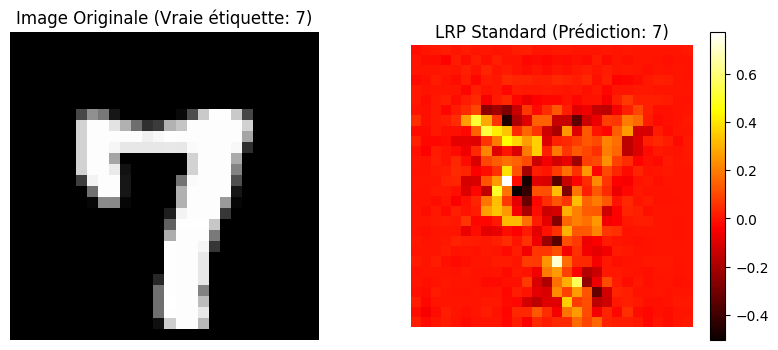

In [ ]:
visualize_lrp(image, label, model, lrp, "LRP Standard")

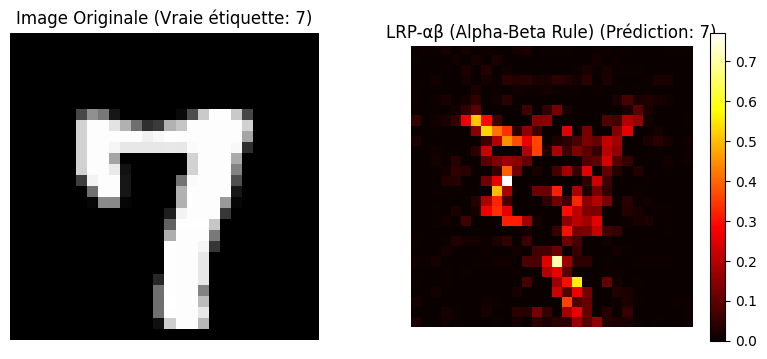

In [ ]:
visualize_lrp(image, label, model, lrp_alpha_beta, "LRP-αβ (Alpha-Beta Rule)")

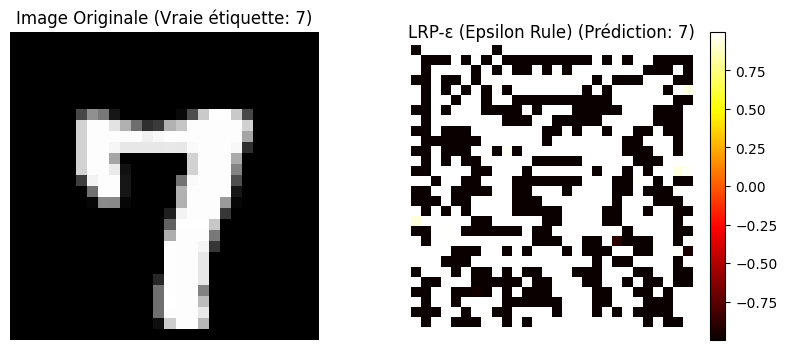

In [ ]:
visualize_lrp(image, label, model, lrp_epsilon, "LRP-ε (Epsilon Rule)")

# Rapport et Analyse Finale

## Objectif du Projet

L'objectif de ce projet est d'appliquer des techniques d'interprétabilité des modèles de Machine Learning en utilisant la méthode LRP (Layer-wise Relevance Propagation) sur un modèle de réseau de neurones convolutif (CNN). Le but principal était de comprendre comment le modèle prend ses décisions lorsqu'il est appliqué à des données du dataset MNIST, qui est spécialisé dans la reconnaissance de chiffres manuscrits. Pour cela, nous avons mis en œuvre trois variantes de la méthode LRP : la méthode standard, la variante LRP-ε et la variante LRP-αβ, afin de comparer les différents résultats d'interprétation.



## Modifications et Améliorations Apportées

Nous avons commencé par établir un modèle CNN adapté au dataset MNIST, en utilisant deux couches convolutives, suivies de couches de pooling et de couches entièrement connectées pour la classification finale. Le modèle a été entraîné pendant cinq époques, et la perte a montré une diminution significative à chaque itération, passant de 0.1498 à 0.0179 à la cinquième époque. Ce résultat indique une convergence rapide du modèle vers une solution optimisée. Pour interpréter les résultats, nous avons intégré trois méthodes LRP afin d'observer les différences dans les cartes de rélevance générées. Chaque méthode a été ajustée pour fonctionner efficacement avec le modèle CNN, en tenant compte des spécificités des activations et des gradients.



## Analyse des Résultats

Les résultats indiquent que le modèle CNN obtient une performance très satisfaisante, avec une perte finale très faible. En analysant les cartes de rélevance, la méthode LRP standard a mis en évidence des zones d'influence clairement définies autour des caractéristiques principales des chiffres, ce qui montre que le modèle se concentre sur des éléments pertinents pour la classification. La variante LRP-ε a aidé à stabiliser les attributions en diminuant les activations parasites, bien que certaines cartes aient montré des motifs plus fragmentés. Enfin, la variante LRP-αβ a permis une meilleure distinction entre les contributions positives et négatives, soulignant les zones qui influencent le plus la décision du modèle, notamment sur les contours des chiffres manuscrits.



## Points Positifs et Limites

Le principal avantage de ce projet réside dans la capacité des méthodes LRP à offrir des explications visuelles claires sur les décisions du modèle. L'interprétabilité obtenue grâce à ces techniques permet de mieux saisir les zones d'intérêt du modèle, ce qui est essentiel dans des contextes où la confiance dans les prédictions est primordiale. Cependant, certaines limitations demeurent, notamment avec la méthode LRP-ε qui peut générer des cartes moins cohérentes selon les paramètres choisis. De plus, la qualité des visualisations peut être affectée par la complexité du modèle et la nature des données d'entrée.



## Conclusion

Ce projet a illustré l'efficacité des méthodes d'interprétabilité LRP appliquées à un modèle CNN, permettant d'obtenir des explications visuelles sur les prédictions réalisées. L'analyse des cartes de rélevance a révélé l'importance des différentes variantes de LRP pour comprendre les mécanismes de décision du modèle. Ces techniques peuvent également être utilisées dans d'autres domaines où l'interprétabilité des modèles est cruciale, favorisant ainsi une meilleure transparence et une plus grande confiance dans les systèmes d'intelligence artificielle